In [2]:
import pandas as pd
import numpy as np
import sys
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split

one_hot_encoded_df = pd.read_csv("data/one_hot_encoded_df.csv")

C:\Users\Daniel\AppData\Local\Temp\ipykernel_23604\307230861.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import torch.nn as nn
embed = nn.Embedding(2,5)
w2idx = {"hi":0, "how":1}
tensor = torch.tensor([w2idx["hi"]],dtype = torch.long)
embed(tensor)

tensor([[-0.4400,  0.0290,  0.4458,  0.2844, -1.3258]],
       grad_fn=<EmbeddingBackward0>)

In [4]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [5]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        # print(log_probs.shape)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    print(loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])

[(['forty', 'When'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege')]
tensor(4.6311, grad_fn=<NllLossBackward0>)
tensor(4.6066, grad_fn=<NllLossBackward0>)
tensor(4.5823, grad_fn=<NllLossBackward0>)
tensor(4.5581, grad_fn=<NllLossBackward0>)
tensor(4.5341, grad_fn=<NllLossBackward0>)
tensor(4.5101, grad_fn=<NllLossBackward0>)
tensor(4.4863, grad_fn=<NllLossBackward0>)
tensor(4.4626, grad_fn=<NllLossBackward0>)
tensor(4.4391, grad_fn=<NllLossBackward0>)
tensor(4.4157, grad_fn=<NllLossBackward0>)
[521.521324634552, 519.1316559314728, 516.7568547725677, 514.3948233127594, 512.0454001426697, 509.7089695930481, 507.3834173679352, 505.0697646141052, 502.7664210796356, 500.4713122844696]
tensor([ 0.0663, -0.4360,  0.7614,  0.4410,  1.1667,  2.0163,  0.1378,  0.9378,
        -0.1852, -0.6452], grad_fn=<SelectBackward0>)


In [6]:
ngrams

[(['forty', 'When'], 'winters'),
 (['winters', 'forty'], 'shall'),
 (['shall', 'winters'], 'besiege'),
 (['besiege', 'shall'], 'thy'),
 (['thy', 'besiege'], 'brow,'),
 (['brow,', 'thy'], 'And'),
 (['And', 'brow,'], 'dig'),
 (['dig', 'And'], 'deep'),
 (['deep', 'dig'], 'trenches'),
 (['trenches', 'deep'], 'in'),
 (['in', 'trenches'], 'thy'),
 (['thy', 'in'], "beauty's"),
 (["beauty's", 'thy'], 'field,'),
 (['field,', "beauty's"], 'Thy'),
 (['Thy', 'field,'], "youth's"),
 (["youth's", 'Thy'], 'proud'),
 (['proud', "youth's"], 'livery'),
 (['livery', 'proud'], 'so'),
 (['so', 'livery'], 'gazed'),
 (['gazed', 'so'], 'on'),
 (['on', 'gazed'], 'now,'),
 (['now,', 'on'], 'Will'),
 (['Will', 'now,'], 'be'),
 (['be', 'Will'], 'a'),
 (['a', 'be'], "totter'd"),
 (["totter'd", 'a'], 'weed'),
 (['weed', "totter'd"], 'of'),
 (['of', 'weed'], 'small'),
 (['small', 'of'], 'worth'),
 (['worth', 'small'], 'held:'),
 (['held:', 'worth'], 'Then'),
 (['Then', 'held:'], 'being'),
 (['being', 'Then'], 'asked

In [7]:
import  torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))
print(data[:5])
word_to_ix = {word: i for i, word in enumerate(vocab)}

class CBOW(nn.Module):

    def __init__(self,vocab_size,embedding_dim):
        super(CBOW,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.fc1 = nn.Linear(embedding_dim*CONTEXT_SIZE*2,vocab_size)

    def forward(self, inputs):
        x = self.embedding(inputs).view(1,-1)
        # print(x.shape )
        x = self.fc1(x)
        # print(x.shape )
        x = F.log_softmax(x)
        return x
# Create your model and train. Here are some functions to help you make
# the data ready for use by your module.


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


make_context_vector(data[0][0], word_to_ix), data[0][0]  # example

[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study'), (['study', 'to', 'idea', 'of'], 'the'), (['the', 'study', 'of', 'a'], 'idea')]


(tensor([ 8, 47, 16, 10]), ['are', 'We', 'to', 'study'])

In [8]:
import torch.optim as optim
model = CBOW(vocab_size, EMBEDDING_DIM)

loss = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001)
loss_list = []
epochs = 10
for epoch in range(epochs):
    for context ,target in data:
        # print(context)
        context_idx = make_context_vector(context,word_to_ix)
        model.zero_grad()
        print(context_idx)

        preds = model(context_idx)

        error = loss(preds,torch.tensor([word_to_ix[target]], dtype=torch.long))
        error.backward()
        
        optimizer.step()
        loss_list.append(error.item())

    print(error)


tensor([ 8, 47, 16, 10])
tensor([46,  8, 10, 24])
tensor([16, 46, 24, 13])
tensor([10, 16, 13, 20])
tensor([24, 10, 20, 29])
tensor([13, 24, 29, 11])
tensor([20, 13, 11, 34])
tensor([29, 20, 34,  7])
tensor([11, 29,  7, 43])
tensor([34, 11, 43,  8])
tensor([ 7, 34,  8, 38])
tensor([43,  7, 38, 40])
tensor([ 8, 43, 40, 36])
tensor([38,  8, 36, 15])
tensor([40, 38, 15, 41])
tensor([36, 40, 41, 19])
tensor([15, 36, 19,  9])
tensor([41, 15,  9,  4])
tensor([19, 41,  4, 43])
tensor([ 9, 19, 43,  2])
tensor([ 4,  9,  2, 39])
tensor([43,  4, 39, 38])
tensor([ 2, 43, 38, 21])
tensor([39,  2, 21, 17])
tensor([38, 39, 17,  1])
tensor([21, 38,  1,  3])
tensor([17, 21,  3, 32])
tensor([ 1, 17, 32, 20])
tensor([ 3,  1, 20, 29])
tensor([32,  3, 29, 27])
tensor([20, 32, 27, 22])
tensor([29, 20, 22,  6])
tensor([27, 29,  6, 45])
tensor([22, 27, 45, 29])
tensor([ 6, 22, 29, 23])
tensor([45,  6, 23, 20])
tensor([29, 45, 20, 33])
tensor([23, 29, 33, 17])
tensor([20, 23, 17, 29])
tensor([33, 20, 29,  5])


C:\Users\Daniel\AppData\Local\Temp\ipykernel_23604\2448344670.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


tensor([24, 10, 20, 29])
tensor([13, 24, 29, 11])
tensor([20, 13, 11, 34])
tensor([29, 20, 34,  7])
tensor([11, 29,  7, 43])
tensor([34, 11, 43,  8])
tensor([ 7, 34,  8, 38])
tensor([43,  7, 38, 40])
tensor([ 8, 43, 40, 36])
tensor([38,  8, 36, 15])
tensor([40, 38, 15, 41])
tensor([36, 40, 41, 19])
tensor([15, 36, 19,  9])
tensor([41, 15,  9,  4])
tensor([19, 41,  4, 43])
tensor([ 9, 19, 43,  2])
tensor([ 4,  9,  2, 39])
tensor([43,  4, 39, 38])
tensor([ 2, 43, 38, 21])
tensor([39,  2, 21, 17])
tensor([38, 39, 17,  1])
tensor([21, 38,  1,  3])
tensor([17, 21,  3, 32])
tensor([ 1, 17, 32, 20])
tensor([ 3,  1, 20, 29])
tensor([32,  3, 29, 27])
tensor([20, 32, 27, 22])
tensor([29, 20, 22,  6])
tensor([27, 29,  6, 45])
tensor([22, 27, 45, 29])
tensor([ 6, 22, 29, 23])
tensor([45,  6, 23, 20])
tensor([29, 45, 20, 33])
tensor([23, 29, 33, 17])
tensor([20, 23, 17, 29])
tensor([33, 20, 29,  5])
tensor([17, 33,  5, 42])
tensor([29, 17, 42, 37])
tensor([ 5, 29, 37, 18])
tensor([42,  5, 18, 16])


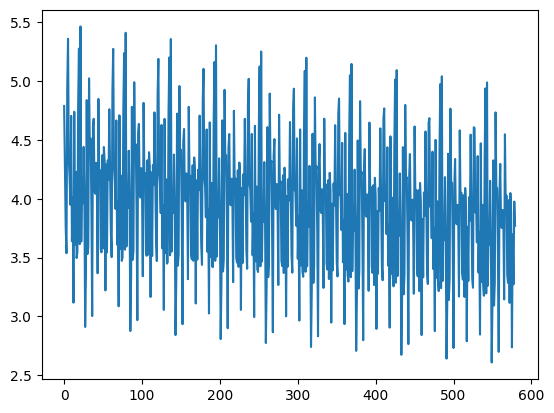

In [9]:
from matplotlib import pyplot as plt
plt.plot(loss_list)